# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
df_interactions = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df_interactions['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df_interactions to get an idea of the data
df_interactions.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
user_interaction_counts = df_interactions.groupby('email').count()['article_id']
user_interaction_counts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

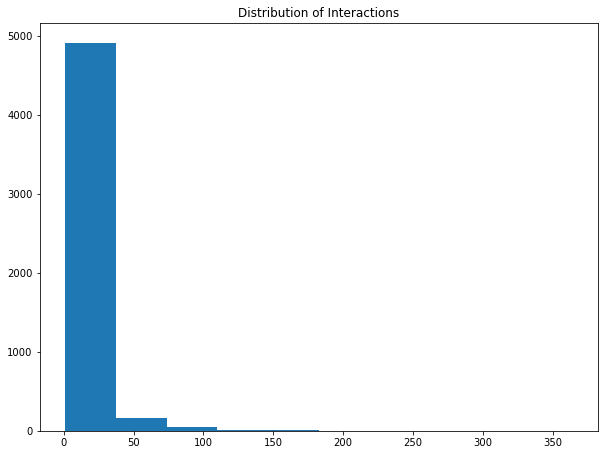

In [4]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.hist(user_interaction_counts)
ax.set_title('Distribution of Interactions')
plt.show();

In [5]:
# Fill in the median and maximum number of user_article interactions below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
len(df_content) - len(df_content['article_id'].drop_duplicates())

5

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
df_interactions['article_id'].nunique()


714

In [9]:
df_content.shape

(1051, 5)

In [10]:
df_interactions['email'].nunique()

5148

In [11]:
df_interactions.shape

(45993, 3)

In [12]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df_interactions.groupby('article_id')['email'].count().sort_values(ascending=False).head(5)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [14]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    counter = 1
    email_encoded = []
    
    for val in df_interactions['email']:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df_interactions['email']
df_interactions['user_id'] = email_encoded

# show header
df_interactions.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
ids = df_interactions['article_id'].value_counts().sort_values(ascending=False).index
print(ids)

articles = df_interactions[df_interactions['article_id'].isin(ids[0:10])]['title'].drop_duplicates().tolist()
print(articles)

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0,
              ...
               653.0, 1237.0, 1092.0,  974.0, 1233.0, 1202.0,  417.0, 1119.0,
              1200.0,  662.0],
             dtype='float64', length=714)
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


In [18]:
def get_top_articles(n, df=df_interactions):
    """
    A function that returns the number of articles defined by n from the dataframe df
    :param n: (int) number of articles to be returned
    :param df: (pandas.core.frame.DataFrame) dataframe from which n articles are to be returned
    :return: (list) a list of n top articles from dataframe df
    """
    # Your code here
    top_articles = list(df.groupby('title').count().sort_values(by='user_id', ascending=False).index)[0:n]

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df_interactions):
    """
    A function that returns the ids of articles defined by n from the dataframe df
    :param n: (int) number of article ids to be returned
    :param df: (pandas.core.frame.DataFrame) dataframe from which n articles are to be returned
    :return: (list) a list of n top article ids from dataframe df
    """
    # Your code here
    top_article_ids = list(df.groupby('article_id').count().sort_values(by='user_id', ascending=False).index)[0:n]

    return top_article_ids # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    """
    A function that accepts a dataframe as input and returns a matrix with user ids as rows and article ids as columns
    The matrix contains 0 and 1 values to indicate whether a user has interacted with an article or not
    :param df: (pandas.core.frame.DataFrame) dataframe that contains the ids of users and the ids of articles they interacted with
    :return: (pandas.core.frame.DataFrame) a dataframe contains user ids as rows and article ids as columns with 0 and 1 values
    """
    # Fill in the function here
    user_article_item = df.groupby(by=['user_id', 'article_id']).agg(lambda x: 1).unstack().fillna(0)
    return user_article_item

user_item = create_user_item_matrix(df_interactions)

In [22]:
# Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [23]:
def find_similar_users(user_id, user_item=user_item):
    """
    A function that calculates the similarity between the given user and others based on the dot product
    :param user_id: (int) Id of the reference user
    :param user_item: (pandas.core.frame.DataFrame) contains the user-article interactions
    :return: (list) an ordered list of similar users
    """
    # Calculate the similarity of each user to the given user
    similar_users = {}
    for user in user_item.index:
        result = []
        # x = [int(i) for i in list(user_item.loc[user_id, :])]
        # y = [int(i) for i in list(user_item.loc[user,:])]
        x = list(user_item.loc[user_id, :])
        y = list(user_item.loc[user,:])
        for i in range(0, len(x)):
            result.append(x[i] * y[i])
        similar_users[user] = sum(result)

    # print(len(similar_users))
    # Drop all zero values
    similar_users = {key: val for key, val in similar_users.items() if val != 0.0}
    # print(len(similar_users))

    # print(similar_users)

    # Sort the calculated similar users dict
    sorted_similar_users = sorted(similar_users.items(), key=lambda x:x[1], reverse=True)
    # sorted_similar_users = sorted(similar_users_list.items(), key=lambda x:x[1], reverse=True)
    # print(sorted_similar_users)

    # Produce a list of only user ids
    most_similar_users = [key for key, value in sorted_similar_users]
    # print(most_similar_users)

    # Eliminate the owner user; in other words, the user id that was input
    most_similar_users.remove(user_id)
    # print(most_similar_users)

    return most_similar_users


In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user.

In [25]:
def get_article_names(article_ids, df=df_interactions):
    """
    A function that returns a list of article names for a given list of article ids from a given dataframe
    :param article_ids: (list) a list of article ids
    :param df: (pandas.core.frame.DataFrame) dataframe that contains details of users and the articles that they have read
    :return: (list) article names corresponding to the input article ids
    """
    # Your code here
    # Convert the list of article id strings to floats
    article_ids_float = [float(element) for element in article_ids]
    article_names = list(set(df[df['article_id'].isin(article_ids_float)]['title']))
    
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    A function that returns a list of article ids and their titles that were read by a user
    :param user_id: (int) input user id
    :param user_item: (pandas.core.frame.DataFrame) dataframe that contains the matrix of user and article ids
    :return: (lists) a list of article ids that were read by the given user; a list of corresponding article names from df_content
    """
    # Your code here
    # First, get a list of article ids from user_item dataframe for the given user id where the interaction equals 1
    article_ids = [str(id) for id in list(user_item.loc[user_id][user_item.loc[user_id] == 1].title.index)]

    # Next, pass the article ids list to get_article_names function to get article names
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    """
    A function that iterates through the users based on proximity to the given user id
    For each such proximate user, return a list of articles that the input user hasn't read before
    Include the top 10 most read articles by users other than the input user in this list
    :param user_id: (int) input user id
    :param m: (int) number of article recommendations; defaults to 10
    :return: (list) articles recommended for the given user id
    """
    # Your code here
    art_ids_read_by_ref_users = []
    most_similar_users = find_similar_users(user_id)
    input_user_art_ids, input_user_art_names = get_user_articles(user_id)
    for ref_user in most_similar_users:
        ref_user_art_ids, ref_user_art_names = get_user_articles(ref_user)
        art_ids_read_by_ref_users.extend(ref_user_art_ids)

    # Eliminate duplicate articles
    unique_art_ids_read_by_ref_users = list(set(art_ids_read_by_ref_users))

    # Eliminate articles read by input user
    art_ids_not_read_by_input_user = list(set(unique_art_ids_read_by_ref_users) - set(input_user_art_ids))

    # Return top ten articles read by most users but not read by input user
    return art_ids_not_read_by_input_user[:m]


In [26]:
# Check Results
# get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1
user_rec_list = user_user_recs(352)
print(user_rec_list)
get_article_names(user_rec_list)

['825.0', '943.0', '382.0', '583.0', '618.0', '862.0', '1165.0', '101.0', '237.0', '111.0']


['what is text analytics?',
 'can a.i. be taught to explain itself?',
 'how to choose a project to practice data science',
 'time series analysis using max/min and neuroscience',
 'what is smote in an imbalanced class setting (e.g. fraud detection)?',
 'deep learning with data science experience',
 'tidy up your jupyter notebooks with scripts',
 'discover hidden facebook usage insights',
 'the million dollar question: where is my data?',
 'analyze precipitation data']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

I took a slightly different approach to solving this problem in the code below. The function user_user_recs_part2() is mostly similar to its previous version with one exception. It now calls a new function called get_top_n_articles().

Instead of picking the first ten available article ids from the list of unread articles, this function ranks the unread articles by the number of users that have read them in descending order. It then returns the top n such articles.

I think that this is a more meaningful approach to recommending articles.

In [56]:
def get_top_n_articles(art_ids, m=10):
    """
    A function that accepts a list of article ids and a top n value and returns
    the top n most read articles by user counts
    :param art_ids: (list) list of article ids
    :param m: (int) defaults to 10
    :return: (list) top n articles read by user counts
    """
    # Return top ten articles read by most users
    df_rec_articles = df_interactions[df_interactions['article_id'].isin(pd.to_numeric(art_ids))][['article_id', 'user_id']].groupby('article_id').count()
    df_rec_articles.sort_values(by='user_id', ascending=False, inplace=True)

    return list(df_rec_articles.index)[:m]


def user_user_recs_part2(user_id, m=10):
    """
    A function that iterates through the users based on proximity to the given user id
    For each such proximate user, return a list of articles that the input user hasn't read before
    Include the top 10 most read articles by users other than the input user in this list
    :param user_id: (int) input user id
    :param m: (int) number of article recommendations; defaults to 10
    :return: (list) articles recommended for the given user id
    """
    # Your code here
    art_ids_read_by_ref_users = []
    most_similar_users = find_similar_users(user_id)
    input_user_art_ids, input_user_art_names = get_user_articles(user_id)
    for ref_user in most_similar_users:
        ref_user_art_ids, ref_user_art_names = get_user_articles(ref_user)
        art_ids_read_by_ref_users.extend(ref_user_art_ids)

    # Eliminate duplicate articles
    unique_art_ids_read_by_ref_users = list(set(art_ids_read_by_ref_users))

    # Eliminate articles read by input user
    art_ids_not_read_by_input_user = list(set(unique_art_ids_read_by_ref_users) - set(input_user_art_ids))

    # Return top ten articles read by most users but not read by input user
    rec_article_ids = get_top_n_articles(art_ids_not_read_by_input_user, m=10)
    rec_article_names = get_article_names(rec_article_ids)

    return rec_article_ids, rec_article_names


def get_top_sorted_users(user_id, df=df_interactions, user_item=user_item):
    """
    A function that sorts the data in the input dataframe by similarity and number of user interactions
    :param user_id: (int) input user id
    :param df: (pandas.core.frame.DataFrame) dataframe that contains details of users and the articles that they have read
    :param user_item: (pandas.core.frame.DataFrame) dataframe that contains the matrix of user-artcile interactions
    :return: (pandas.core.frame.DataFrame) dataframe that contains the neighboring user id, measure of similarity and number of interactions
    """
    # Your code here
    # Initialize a dict to hold the values to be saved to a dataframe
    similar_users = {}
    for user in user_item.index:
        result = []
        if user != user_id:
            x = list(user_item.loc[user_id, :])
            y = list(user_item.loc[user,:])
            for i in range(0, len(x)):
                result.append(x[i] * y[i])
            similar_users[user] = sum(result)
    df_sim_users = pd.DataFrame.from_dict(similar_users, orient='index')
    df_interactions_agg = df.groupby('user_id').count()['article_id']
    df_sim_users = pd.merge(df_sim_users, df_interactions_agg, left_index=True, right_index=True)
    df_sim_users.reset_index(inplace=True)
    df_sim_users = df_sim_users.rename(columns={'index': 'user_id', 0: 'similarity', 'article_id': 'interactions'})
    df_sim_users.sort_values(by=['similarity', 'interactions'], ascending=False, inplace=True)

    return df_sim_users


In [235]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]

The top 10 recommendations for user 20 are the following article names:
['use xgboost, scikit-learn & ibm watson machine learning apis', 'visualize car data with brunel', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'use deep learning for image classification', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization', 'predicting churn with the spss random tree algorithm']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [58]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0][0]   # Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131).iloc[9][0]   # Find the 10th most similar user to user 131

In [59]:
user1_most_sim

3933.0

In [60]:
user131_10th_sim

242.0

In [61]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Using get_top_article_ids() would be a better option to make recommendations since the user hasn't viewed any articles before and we have no information about the user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [62]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)]    # Your recommendations here



In [63]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [36]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [37]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [64]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [65]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [66]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)  # use the built-in to get the three matrices

The numpy SVD works in cases where there are no unknown values. The matrix in the lesson had many unknown values and so FunkSVD was used. In this case, the matrix has binary values of 1 and 0 to indicate whether the user has interacted with an article (1) or not (0).

In [67]:
print('Users: %d' %u.shape[0])
print('Latent Features: %d' %u.shape[1])

Users: 5149
Latent Features: 714


In [68]:
print('Latent Features: %d' %s.shape[0])

Latent Features: 714


In [69]:
print('Latent Features: ', vt.shape)


Latent Features:  (714, 714)


In the lesson, the user_item_matrix already contains the rating. However, in this project, we can only ascertain whether the user has viewed that article or not.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

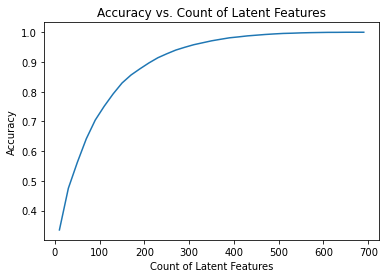

In [71]:
latent_features_count = np.arange(10,700+10,20)
sum_of_errors = []

for item in latent_features_count:
    # Recompute with "item" latent features
    s_new, u_new, vt_new = np.diag(s[:item]), u[:, :item], vt[:item, :]
    
    # Calculate the dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Calculate the error between each prediction and actual value
    differences = np.subtract(user_item_matrix, user_item_est)
    
    # Add up the errors
    error = np.sum(np.sum(np.abs(differences)))
    sum_of_errors.append(error)
    
    
plt.plot(latent_features_count, 1 - np.array(sum_of_errors) / df_interactions.shape[0]);
plt.xlabel('Count of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Count of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [72]:
df_train = df_interactions.head(40000)
df_test = df_interactions.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    """
    This function accepts train and test data and returns user_item_matrices - one for training and another for testing
    It also returns all the user and article ids used in testing
    :param df_train: (pandas.core.frame.DataFrame) training dataset
    :param df_test: (pandas.core.frame.DataFrame) testing dataset
    :return: The funtion returns the following:
        user_item_train: (pandas.core.frame.DataFrame) a user-item matrix of the training dataframe
        user_item_test: (pandas.core.frame.DataFrame) a user-item matrix of the testing dataframe
        test_user_ids: (list) a list of test user ids
        test_articles_ids: (list) a list of article ids
    """
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_user_ids = user_item_test.index.values
    test_article_ids = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_user_ids, test_article_ids

user_item_train, user_item_test, test_user_ids, test_article_ids = create_test_and_train_user_item(df_train, df_test)

In [73]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [74]:
# Count of users that we can make predictions for
train_user_ids = user_item_train.index.values
count_test_users_with_prediction = len(np.intersect1d(test_user_ids, train_user_ids))
count_test_users_with_prediction

20

In [75]:
# Count of users that we can NOT make predictions for
count_test_users_wo_prediction = len(test_user_ids) - count_test_users_with_prediction
count_test_users_wo_prediction

662

In [76]:
# Count of articles that we can make predictions for
train_article_ids = user_item_train.columns.values
test_article_ids = user_item_test.columns.values

count_test_articles_with_prediction = len(np.intersect1d(test_article_ids, train_article_ids))
count_test_articles_with_prediction

574

In [77]:
# Count of articles that we can NOT make predictions for
count_test_articles_wo_prediction = len(test_article_ids) - count_test_articles_with_prediction
count_test_articles_wo_prediction

0

In [78]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.

In [79]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False) # fit svd similar to above then use the cells below

In [80]:
print('u_train: ', u_train.shape)
print('s_train: ', s_train.shape)
print('vt_train: ', vt_train.shape)


u_train:  (4487, 714)
s_train:  (714,)
vt_train:  (714, 714)


In [81]:
# Identify the subset of u_train that is in test
u_test = u_train[user_item_train.index.isin(test_user_ids), :]
print('u_test: ', u_test.shape)

u_test:  (20, 714)


In [82]:
# Identify the subset of vt_train that is in test
vt_test = vt_train[:, user_item_train.columns.isin(test_article_ids)]
print('vt_test: ', vt_test.shape)

vt_test:  (714, 574)


In [83]:
# Identify the subset of user_item_test for which we can obtain predictions
test_user_ids_with_pred = np.intersect1d(test_user_ids, train_user_ids)

user_item_test_subset = user_item_test[user_item_test.index.isin(test_user_ids_with_pred)]
print('user_item_test_subset: ', user_item_test_subset.shape)

user_item_test_subset:  (20, 574)


In [84]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data

latent_features_count2 = np.arange(10, 700 + 10, 20)

train_accuracy_list = []
test_accuracy_list = []
train_f1_list = []
test_f1_list = []

for item in latent_features_count2:
    new_u_train, new_s_train, new_vt_train = u_train[:,:item], np.diag(s_train[:item]), vt_train[:item,:]
    new_u_test, new_vt_test = u_test[:,:item], vt_test[:item,:]

    user_item_train_prediction = np.around(np.dot(np.dot(new_u_train, new_s_train), new_vt_train))
    user_item_test_prediction = np.around(np.dot(np.dot(new_u_test, new_s_train), new_vt_test))

    # Clip predictions to the range of 0 and 1 values since we are only predicting whether the user will interact with articles or not
    user_item_train_prediction = np.clip(user_item_train_prediction, 0, 1)
    user_item_test_prediction = np.clip(user_item_test_prediction, 0, 1)

    # Calculate accuracy scores for this iteration
    accuracy_score_train = accuracy_score(np.array(user_item_train).flatten(), user_item_train_prediction.flatten())
    accuracy_score_test = accuracy_score(np.array(user_item_test_subset).flatten(), user_item_test_prediction.flatten())

    # Calculate f1 score for this iteration
    f1_score_train = f1_score(np.array(user_item_train).flatten(), user_item_train_prediction.flatten())
    f1_score_test = f1_score(np.array(user_item_test_subset).flatten(), user_item_test_prediction.flatten())

    train_accuracy_list.append(accuracy_score_train)
    test_accuracy_list.append(accuracy_score_test)

    train_f1_list.append(f1_score_train)
    test_f1_list.append(f1_score_test)

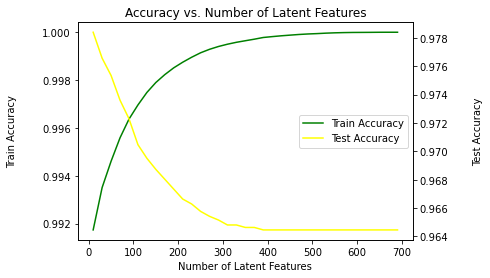

In [85]:
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();

ax1.plot(latent_features_count2, train_accuracy_list, color='green', label="Train Accuracy");
ax2.plot(latent_features_count2, test_accuracy_list, color='yellow', label="Test Accuracy");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Accuracy vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Accuracy', labelpad=25);
ax2.set_ylabel('Test Accuracy', labelpad=25);

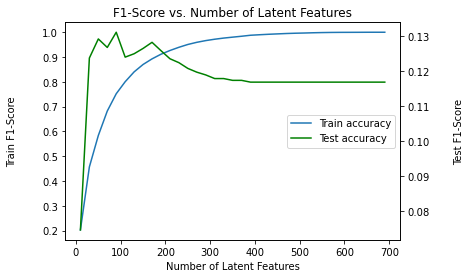

In [86]:
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();

ax1.plot(latent_features_count2, train_f1_list, label="Train accuracy");
ax2.plot(latent_features_count2, test_f1_list, color='green', label="Test accuracy");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('F1-Score vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train F1-Score', labelpad=25);
ax2.set_ylabel('Test F1-Score', labelpad=25);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Reviewing the results obtained so far, it seems like there is a great difference between the class of 0 and 1 values representing whether a user has read an article or not. There are more 0 values than 1 values indicating that many articles are not read by all users. The trouble with such disparity in the data is that it can show up as a super fit since the percentage of 0 values to the total is greater than the percentage of 1 values. This helps with calculating a good accuracy with articles not read compared to the ones that are read.

We can consider dealing with this super fit by (i) getting more data, (ii) cross-validating and (iii) by reducing the extent of latent resources.

The F1 score chart shows us that the test accuracy declines after reaching a peak value of 0.13. This is actually at a lower number of latent features used. And it is mostly flat with an increase in latent features. This leads me to think that I may not be able to use this model for accurate predictions in a production environment. More so since we didn't use many users (user count of 20).

Possibly, classifying articles into subject groups may help improve prediction. It may be easier to recommend articles to users based on the subjects that the articles belong to. This may add more complexity to the model, but it may also improve the accuracy of the predictions.

Additionally, a good test could possibly be done by dividing the users into control groups so that A/B tests can be performed on them. One group may use the recommendations that we devised above while the other group uses recommendations that are based on classification of articles and a measurement of the quality of their contents. We could do the latter by improving on the content dataset to include these metrics. This way, we can assess which recommendation is better.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [87]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1